# Extended Kalman Filter

EKF(Extended Kalman Filter、拡張カルマンフィルタ）はガウシアンフィルタの1つです。

位置推定を行う際にも用いられます。

本ページでは、2次元の平面上でロボットがランドマークを観測しながら（拡張）カルマンフィルタで自己位置を推定します。

注がある場合を除き、本ページに掲載されているコードはMITライセンスに、文章はクリエイティブ・コモンズ・ライセンスに基づいて公開します。

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>

## Requirements

Python 3を必要とします。

## References

S. Thrun, W. Burgard and D. Fox (著), 上田 (訳): 確率ロボティクス, 毎日コミュニケーションズ, 2007

拡張カルマンフィルタでは状態遷移確率は$g$に、計測確率は$h$に（$g,h$はともに非線形関数）従うと仮定して次のようにモデル化します。

\begin{eqnarray}
x_t &=& g(u_t, x_{t-1})+\epsilon_t \\
z_t &=& h(x_t) + \delta_t
\end{eqnarray}

$g,h$ともに非線形であり、共分散行列を直接求めることができません。
線形近似することで、線形カルマンフィルタと同様に予測ステップと修正ステップを繰り返し、
システムを推定・制御することが可能になります。

In [1]:
# 数値計算及び描画に必要なモジュール
import numpy as np
import math, random
from copy import copy
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

# アニメーション作成・表示に必要なモジュール
from matplotlib import animation
from IPython.display import HTML

In [2]:
class Gaussian2D:
    """
    描画の際の計算や尤度の計算に使用する2次元ガウス分布
    mu_x : 中心のX座標（以下X）
    mu_y : 中心のY座標（以下Y）
    sigma_x : Xの分散
    sigma_y : Yの分散
    cov_xy : XYの共分散
    """
    def __init__(self, sigma_x = 1.0, sigma_y = 1.0, cov_xy = 0.0, mu_x = 0.0, mu_y = 0.0):
        """
        共分散行列と中心の座標を定義
        """
        self.cov = np.array([[sigma_x ** 2, cov_xy], [cov_xy, sigma_y ** 2]])
        self.mean = np.array([mu_x, mu_y])
        
    def shift(self, delta, angle):
        """
        ガウス分布の移動
        """
        # 2次元回転行列（反時計回りが正回転）
        rot2d = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
        # 共分散行列は正方行列でベクトルではないので注意
        self.cov = rot2d.T.dot(self.cov).dot(rot2d)
        self.mean = self.mean + delta
        
    def value(self, pos):
        """
        密度の算出
        """
        delta = pos - self.mean
        numerator = math.exp(-0.5 * (delta.T).dot(np.linalg.inv(self.cov)).dot(delta))
        denominator = 2 * math.pi * math.sqrt(np.linalg.det(self.cov))
        return numerator / denominator

In [3]:
class Landmarks:
    """
    landmarks = Landmarks([[x1, y1], [x2, y2], ... , [x, y]])
    引数にランドマークのX座標とY座標を配列で指定
    """
    def __init__(self, array):
        """
        ランドマークの座標を配列で取得
        あとで計算処理しやすくするため、numpyのarrayに変換
        """
        self.positions = np.array(array)
    
    def draw(self):
        """
        取得したすべてのランドマークの座標をプロット
        """
        xs = [ e[0] for e in self.positions]
        ys = [ e[1] for e in self.positions]
        plt.scatter(xs, ys, s=300, marker='*', label='landmarks', color='orange')

In [4]:
class EKF:
    """
    EKF
    """
    def __init__(self, robot_pos):
        #self.bel_pos =  robot_pos
        self.bel_pos = np.array([[0.0],
                                 [0.0],
                                 [0.0]])
        print("initial robot_pos", self.bel_pos)
        self.cov_t = np.eye(3)
        self.debug = False
        
    def prediction_step(self, distance, direction):
        """
        """
        if self.debug : print("bel_pos(t-1)", self.bel_pos)
        # 更新間隔
        delta_t = 1.0
        # 誤差パラメータ
        # 10[%]
        alpha = np.array([0.1, 0.1, 0.1, 0.1])
        # 移動速度
        vel_t = distance / delta_t
        # 移動角速度
        omega_t = direction / delta_t
        
        # 予測ステップ
        # 動作モデルのヤコビアン
        G_t = np.array([[1, 0, distance/direction*(-math.cos(self.bel_pos[2][0])+math.cos(self.bel_pos[2][0]+direction))],
                        [0, 1, distance/direction*(-math.sin(self.bel_pos[2][0])+math.sin(self.bel_pos[2][0]+direction))],
                        [0, 0, 1]])
        if self.debug : print("G_t",G_t)
        V_t = np.array([[(-math.sin(self.bel_pos[2][0])+math.sin(self.bel_pos[2][0]+direction))/omega_t, vel_t*(math.sin(self.bel_pos[2][0])-math.sin(self.bel_pos[2][0]+direction))/omega_t**2 + vel_t*math.cos(self.bel_pos[2][0]+direction)*delta_t/omega_t],
                        [(math.cos(self.bel_pos[2][0])-math.cos(self.bel_pos[2][0]+direction))/omega_t, -vel_t*(math.cos(self.bel_pos[2][0])-math.cos(self.bel_pos[2][0]+direction))/omega_t**2 + vel_t*math.sin(self.bel_pos[2][0]+direction)*delta_t/omega_t],
                        [0, delta_t]])
        if self.debug : print("V_t", V_t)
        M_t = np.array([[alpha[0]*vel_t**2 + alpha[1]*omega_t**2, 0],
                        [0, alpha[2]*vel_t**2 + alpha[3]*omega_t**2]])
        if self.debug : print("M_t", M_t)
        
        self.bel_pos = self.bel_pos + np.array([[-math.sin(self.bel_pos[2][0])+math.sin(self.bel_pos[2][0]+direction)],
                                                [math.cos(self.bel_pos[2][0])-math.cos(self.bel_pos[2][0]+direction)],
                                                [direction]])
        if self.debug : print("priori bel_pos(t)", self.bel_pos)
        
        self.cov_t = G_t.dot(self.cov_t).dot(G_t.T) + V_t.dot(M_t).dot(V_t.T)
        if self.debug : print("cov(t)", self.cov_t)
        
    def update_step(self, obss, landmarks):
        # 修正ステップ
        
        if self.debug : print("landmarks", landmarks)
        
        Q_t = np.array([[0.01, 0, 0],
                        [0, 0.01, 0],
                        [0, 0, 0.01]])
        if self.debug : print("Q_t", Q_t)
        
        for obs in obss:
            
            q = (landmarks.positions[obs[1]][0] - self.bel_pos[0][0]) ** 2 + (landmarks.positions[obs[1]][1] - self.bel_pos[1][0]) ** 2
            
            z_hat_t = np.array([[math.sqrt(q)],
                                [math.atan2((landmarks.positions[obs[1]][1] - self.bel_pos[1][0]), (landmarks.positions[obs[1]][0] - self.bel_pos[0][0])) - self.bel_pos[2][0]],
                                [obs[1]]])
            if self.debug : print("z_hat_t", z_hat_t)
            
            z_t = np.array([[obs[0].distance],
                            [obs[0].direction],
                            [obs[1]]])
            if self.debug : print("z_t", z_t)

            H_t = np.array([[-(landmarks.positions[obs[1]][0] - self.bel_pos[0][0])/math.sqrt(q), -(landmarks.positions[obs[1]][1] - self.bel_pos[1][0])/math.sqrt(q), 0],
                            [(landmarks.positions[obs[1]][0] - self.bel_pos[0][0])/math.sqrt(q), -(landmarks.positions[obs[1]][1] - self.bel_pos[1][0])/math.sqrt(q), -1],
                            [0, 0, 0]])
            if self.debug : print("H_t", H_t)

            S_t = H_t.dot(self.cov_t).dot(H_t.T) + Q_t
            if self.debug : print("S_t", S_t)
            
            K_t = self.cov_t.dot(H_t.T).dot(np.linalg.inv(S_t))
            if self.debug : print("K_t", K_t)
            
            self.bel_pos = self.bel_pos + K_t.dot(z_t - z_t)
            if self.debug : print("posteriori bel_pos(t)", self.bel_pos)
            
            self.cov_t = (np.eye(3) - K_t.dot(H_t)).dot(self.cov_t)
            if self.debug : print("cov_t", self.cov_t)
        
    def draw(self, subplot, color='blue', label='belief'):
        """
        推定される位置を描画するためのメソッド
        """
        xs = self.bel_pos[0][0]
        ys = self.bel_pos[1][0]
        vxs = math.cos(self.bel_pos[2][0])
        vys = math.sin(self.bel_pos[2][0])
        sub_color = color
        sub_label = label
        subplot.quiver(xs, ys, vxs, vys, color = sub_color, label = sub_label)

In [5]:
class Robot:
    """
    robot = Robot(0,0,0)
    ロボットの動作を決めるためのクラス
    ロボットは現在の自身の座標を把握できません。
    そのため、描画のための座標は別のクラスで管理します。
    """
    def __init__(self, x = 0, y = 0, rad = 0):
        self.motion = RobotMotion(x, y, rad)
        self.ekf = EKF(np.array([x, y, rad]))
    
    def move(self, distance, direction):
        self.motion.updatePos(distance, direction)
        self.ekf.prediction_step(distance, direction)
        
    def draw(self, subplot, obss):
        self.motion.draw(subplot, obss)
        self.ekf.draw(subplot)
        
    def observation(self, landmakrs):
        obss = self.motion.observation(landmarks)
        self.ekf.update_step(obss, landmarks)
        return obss

class RobotMotion:
    """
    ロボットの描画のためのクラス
    ロボットの動作を決めるのはこのクラスではありません。
    """
    def __init__(self, x, y, theta):
        """
        ロボットの座標、角度を配列で取得、保存
        あとで計算処理しやすくするため、numpyのarrayに変換
        """
        self.actual_poses = [np.array([x, y, theta])]
        
        # パーティクルフィルタの準備
        # self.pf = ParticleFilter(30)
        
    
    def draw(self, subplot, obss, color = 'red',label = 'actual robot motion'):
        """
        ロボットの座標、角度情報を元にベクトルを描画
        """
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        sub_color = color
        sub_label = label
        subplot.quiver(xs, ys, vxs, vys, color = sub_color, label = sub_label)
        
        # for obs in obss:
        #     for p in self.pf.particles:
        #         obs.draw(subplot, p.pos)

        # self.pf.draw(subplot)
        
        for obs in obss:
            obs[0].draw(subplot, self.actual_poses[-1])
        

    def motion(self, robot_pos, distance, direction):
        """
        ロボットを移動
        進む距離、進む角度を元に移動する先の座標をnumpyのarray形式で返す
        """
        # 移動距離に10%の標準偏差
        actual_distance = random.gauss(distance, distance * 0.1)
        # 進む角度に10%の標準偏差
        actual_direction = random.gauss(direction, direction * 0.1)
        # 移動方向に対して3[deg]の標準偏差
        dir_error = random.gauss(0.0, np.radians(3))
        px, py, pth = robot_pos
        x = px + actual_distance * math.cos(pth)
        y = py + actual_distance * math.sin(pth)
        th = pth + actual_direction + dir_error
        return np.array([x, y, th])
        
    def updatePos(self, distance, direction):
        """
        ロボットとパーティクルを移動
        進む距離、進む角度を元に位置情報を更新
        """
        self.actual_poses.append(self.motion(self.actual_poses[-1], distance, direction))
        # self.pf.moveParticles(distance, direction, self.motion)
        
    def observation(self, landmarks):
        obss = []
        # すべてのランドマークについて、観測できるか確認
        for i,landmark in enumerate(landmarks.positions):
            # ランドマークの観測結果を保存
            obs = Observation(landmark)
            obs.measure(self.actual_poses[-1])
            # センサの範囲内だったランドマークをリストに追加
            if obs.distance != None:
                obss.append([obs, i])

        # パーティクルの重みに尤度をかける
        # for obs in obss:
        #     for p in self.pf.particles:
        #         p.w *= obs.likelihood(p.pos)

        # 観測結果をリストで返す
        return obss

In [6]:
class Observation:
    """
    ロボットの観測モデル
    """
    def __init__(self, landmark_pos, max_range = 1.0, min_range = 0.1, max_angle = (math.pi / 2), min_angle = (-math.pi / 2)):
        # ランドマークの位置を保存
        self.landmark_x, self.landmark_y = landmark_pos
        # センサの計測できる範囲を設定
        self.sensor_max_range = 1.5
        self.sensor_min_range = 0.1
        self.sensor_max_angle = math.pi / 2
        self.sensor_min_angle = - math.pi /2 
        
        # 観測できない場合のセンサ値を決めておく（ここではNone）
        # 観測できた場合はこの値を上書きする
        self.distance, self.direction, self.error_ellipse = None, None, None
        
        # センサの値を取得してセンサの観測範囲内に対象物があるかチェックする
        # 対象物があれば、&IDを保存
        #self.distance, self.direction, self.error_ellipse = self.measure(robot_pos, landmark)
        #self.lid = lid if (self.distance != None) else None 

    def measure(self, robot_pos):
        """
        センサの値を取得してセンサの観測範囲内に対象物があるかチェックする
        """
        # ロボットの位置(ロボット自身は観測不可能)を一時保存
        robot_x, robot_y, robot_th = robot_pos
        
        # センサの計測距離範囲内かどうか確認する
        self.distance_x = self.landmark_x - robot_x
        self.distance_y = self.landmark_y - robot_y
        distance = math.sqrt(self.distance_x ** 2 + self.distance_y ** 2)
        if not distance < self.sensor_max_range and distance > self.sensor_min_range:
            return
        
        # センサの計測角度範囲内かどうか確認する
        direction = math.atan2((self.landmark_y - robot_y),(self.landmark_x - robot_x)) - robot_th
        if direction > math.pi:
            direction -= math.pi * 2
        if direction < math.pi:
            direction += math.pi * 2
        if not direction < self.sensor_max_angle and direction > self.sensor_min_angle:
            return
        
        # 真値に混入する雑音の大きさ（標準偏差）を設定
        sigma_distance = distance * 0.1           # 距離に対して10%の標準偏差
        sigma_direction = np.radians(3)    # ランドマークの方向に対して3degの標準偏差
        
        # 雑音を混ぜてセンサの値とする
        actual_distance = random.gauss(distance, sigma_distance)   
        actual_direction = random.gauss(direction, sigma_direction)
     
        # ロボット座標系での共分散行列を作っておく。あとで尤度を計算するときに使用
        # x方向が奥行きで、sigma_distanceを標準偏差に設定。y方向がロボットから見て横方向の誤差で、距離*sin(3[deg])となる。
        error_ellipse = Gaussian2D(sigma_x = sigma_distance, sigma_y = actual_distance * math.sin(sigma_direction) , cov_xy = 0.0)
        
        #return actual_distance, actual_direction, error_ellipse
        self.distance, self.direction, self.error_ellipse = actual_distance, actual_direction, error_ellipse

    def likelihood(self,particle_pos): 
        # パーティクルの姿勢と、このインスタンスに保存されているセンサの値から、ランドマークの位置を求める
        rx, ry, rt = particle_pos
        proposed_lx = rx + self.distance * math.cos(rt + self.direction)
        proposed_ly = ry + self.distance * math.sin(rt + self.direction)
                
        # このインスタンスに保存されている共分散行列を、計算されたランドマークの位置に移動
        # 移動後、パーティクルの向きに合わせて共分散行列を回転
        e = copy(self.error_ellipse)
        e.shift(np.array([proposed_lx, proposed_ly]).T, rt + self.direction)

        # そのままガウス分布の計算式から密度（尤度）を返す
        return e.value(np.array([self.landmark_x,self.landmark_y]).T)

    def draw(self,subplot,robot_pos):
        rx, ry, rt = robot_pos[0], robot_pos[1], robot_pos[2]
        proposed_lx = rx + self.distance * math.cos(rt + self.direction)
        proposed_ly = ry + self.distance * math.sin(rt + self.direction)
        
        e = copy(self.error_ellipse)
        e.shift(np.array([proposed_lx, proposed_ly]).T, rt + self.direction)
        
        eigen = np.linalg.eig(e.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        elli = Ellipse([proposed_lx, proposed_ly],width=math.sqrt(np.linalg.norm(v1)),height=math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
        elli.set_alpha(0.2)
        
        subplot.add_artist(elli)

In [7]:
# 新規ウィンドウと座標軸用subplotを用意
# タイトルは個別につけるので今は指定しない
fig, world = plt.subplots(figsize=(8, 8))

# ランドマークの座標を指定
landmarks = Landmarks([[-0.5, 0.0], [0.5, 0.0], [0.0, 0.5]])

# ロボットの座標を指定
robot = Robot(0,0,0)

# アニメーション作成の初期処理
# 初期処理を指定しないと、更新処理が1回分多く呼び出される
def init():
    pass

# アニメーション作成の更新処理
def update(i):
    # 座標軸用subplotの描画内容を一度クリア
    plt.cla()
    # 座標軸の範囲を指定
    world.set_xlim(-2.0,2.0)
    world.set_ylim(-1.5,2.5)
    # ランドマークを描画
    landmarks.draw()
    # ロボットを移動
    robot.move(0.2, np.radians(20))
    # 移動後の位置でランドマークを観測
    obss = robot.observation(landmarks)
    # ロボットを描画
    robot.draw(world, obss)
    # タイトルを追加
    plt.title("Robot Motion : frame{0:04d}".format(i))
    # 左上に凡例を追加
    world.legend(loc='upper left')

# アニメーションの作成
anim = animation.FuncAnimation(fig, update, init_func=init, interval=500, frames=20)

initial robot_pos [[ 0.]
 [ 0.]
 [ 0.]]


In [8]:
HTML(anim.to_html5_video())

initial robot_pos [[ 0.]
 [ 0.]
 [ 0.]]


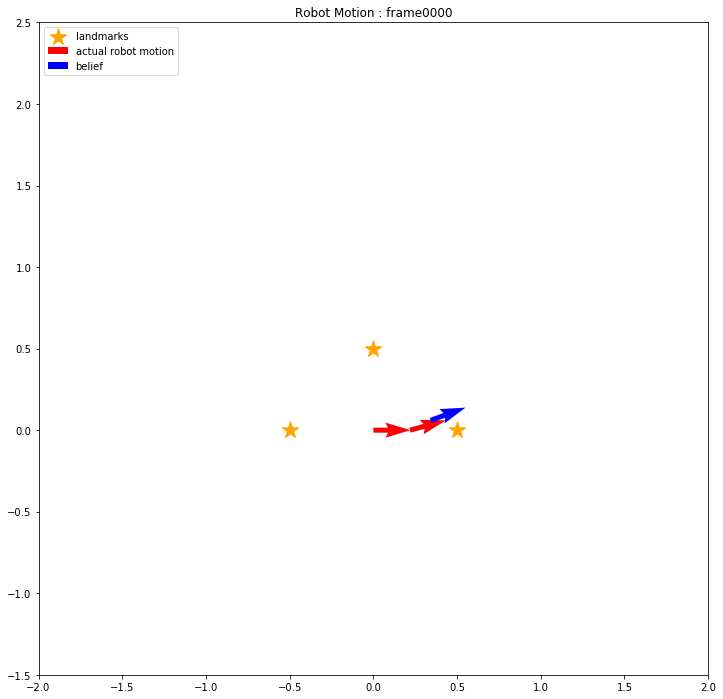

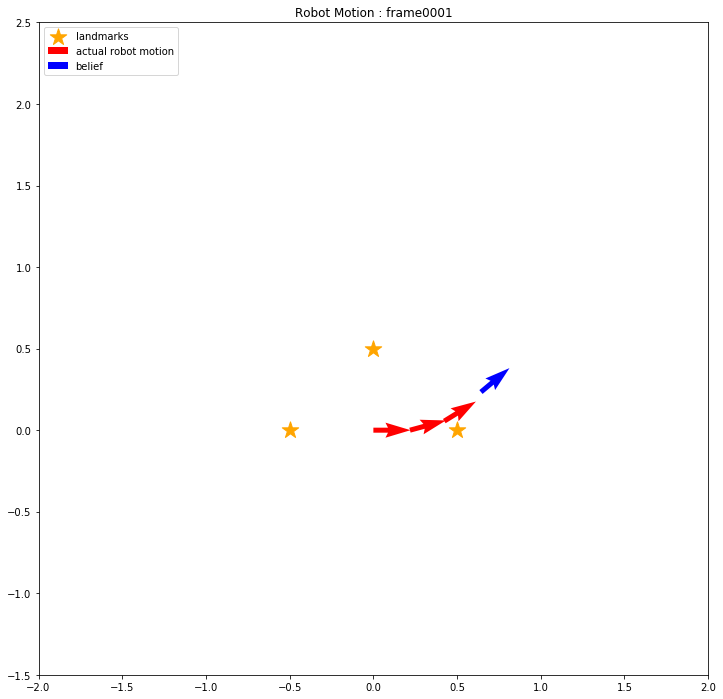

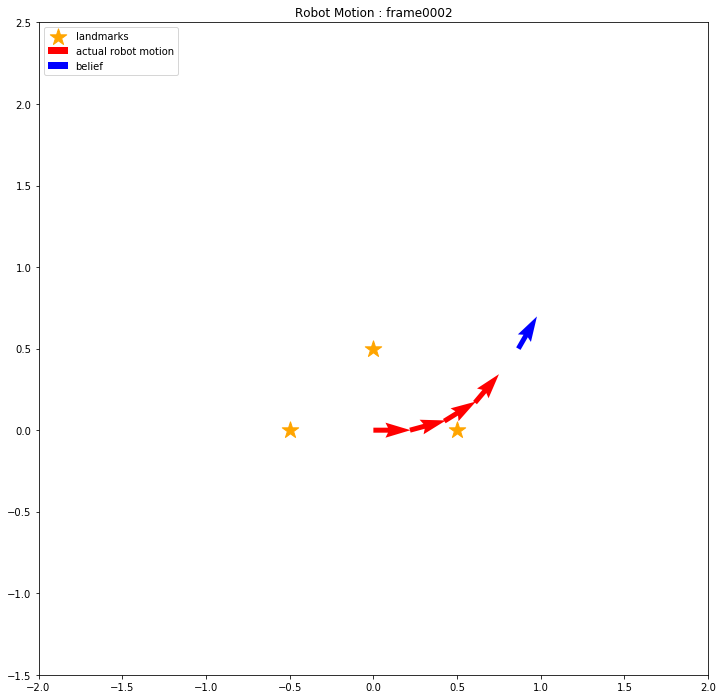

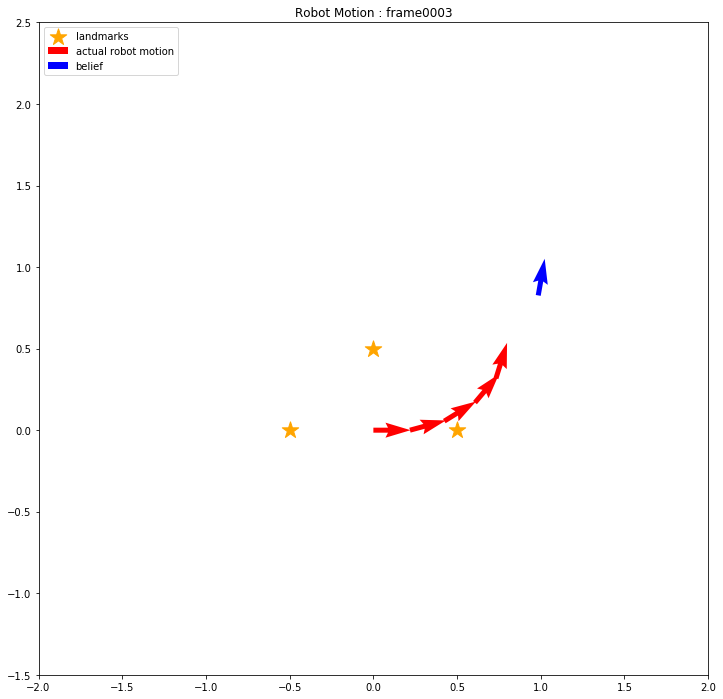

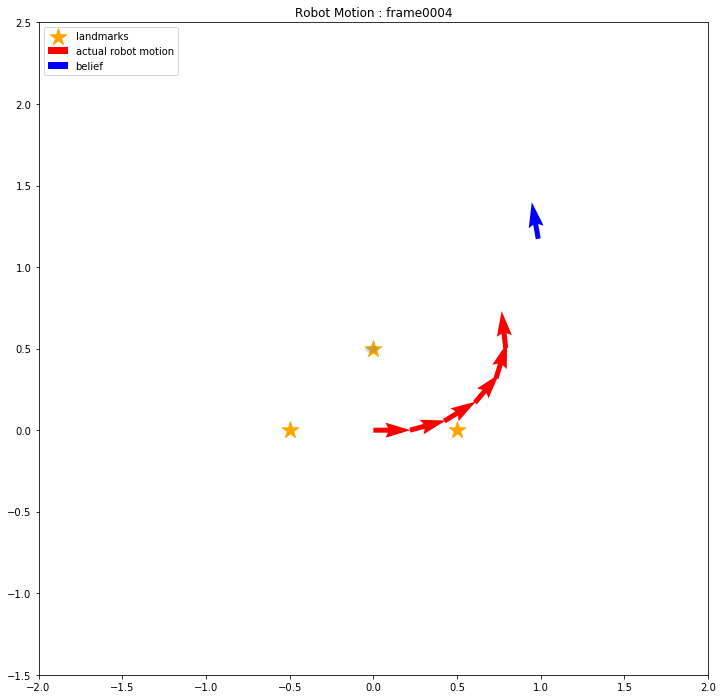

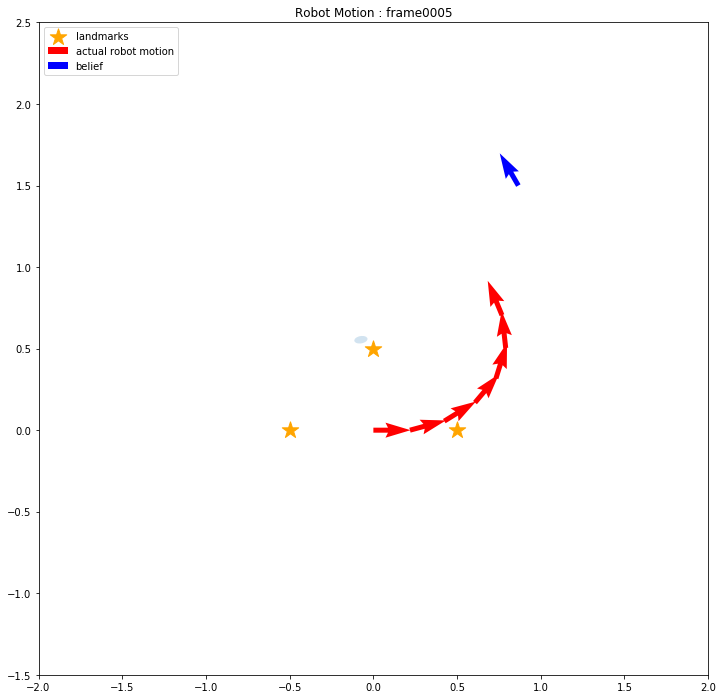

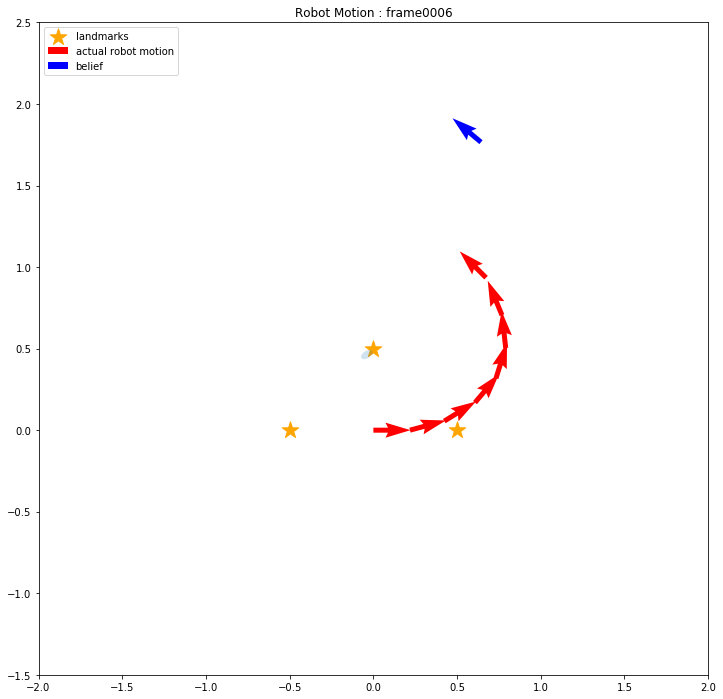

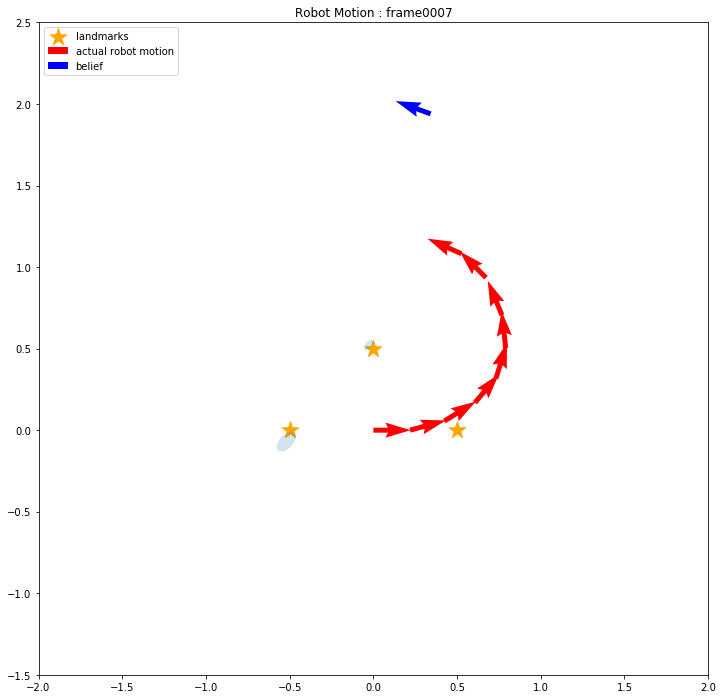

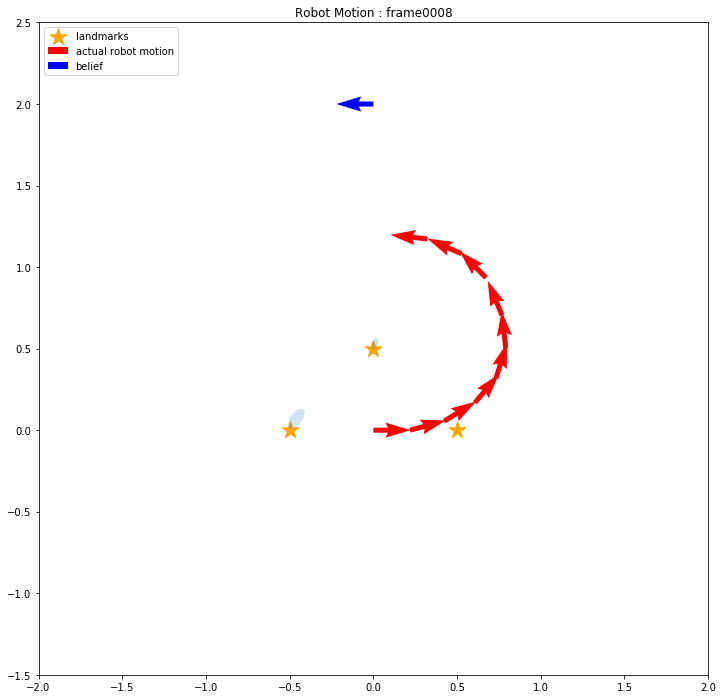

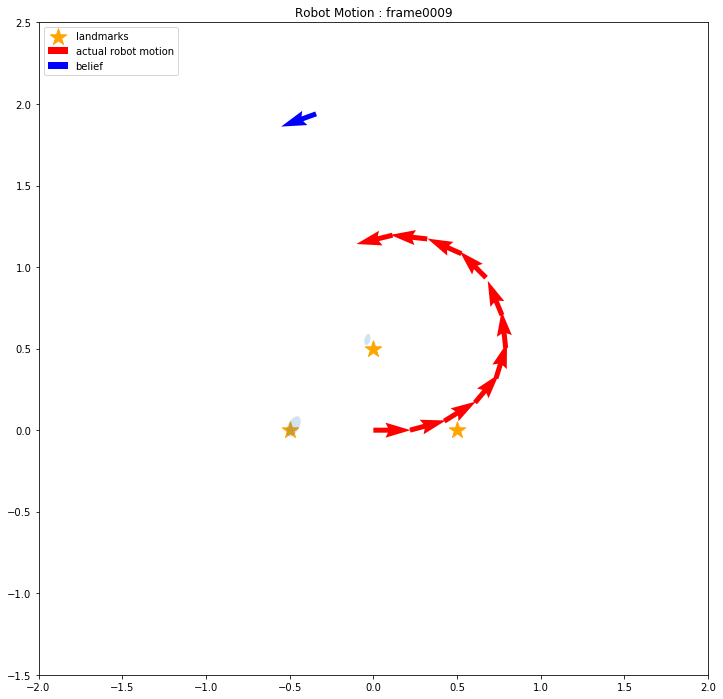

In [9]:
# figureの初期化
plt.close()

# ランドマークの座標を指定
landmarks = Landmarks([[-0.5, 0.0], [0.5, 0.0], [0.0, 0.5]])

# ロボットの座標を指定
robot = Robot(0,0,0)

# アニメーション作成の更新処理
def update(i):
    # 新規ウィンドウと座標軸用subplotを用意
    # タイトルは個別につけるので今は指定しない
    fig, world = plt.subplots(figsize=(12, 12))
    # 座標軸の範囲を指定
    world.set_xlim(-2.0,2.0)
    world.set_ylim(-1.5,2.5)
    # ランドマークを描画
    landmarks.draw()
    # ロボットを移動
    robot.move(0.2, np.radians(20))
    # 移動後の位置でランドマークを観測
    obss = robot.observation(landmarks)
    # ロボットを描画
    robot.draw(world, obss)
    # タイトルを追加
    plt.title("Robot Motion : frame{0:04d}".format(i))
    # 左上に凡例を追加
    world.legend(loc='upper left')

# アニメーションの作成
for i in range(0, 10):
    update(i)
    plt.show()